In [1]:
import GetOldTweets3 as got
import pandas as pd
import numpy as np
import datetime
import re
import os

# Redefinndo path
os.chdir("C:\\Users\\aliss\\Documents\\Nova IMS\\Cursos\\Text Mining\\Final Project")

### 1 - Capturando tweets

In [ ]:
# Select tweets using the key words

tweetCriteria = got.manager.TweetCriteria().setQuerySearch("#bolsonaropresidente lang:pt")\
                                           .setSince("2019-01-02")\
                                           .setUntil("2019-03-01")\
                                           .setMaxTweets(10)
tweets = got.manager.TweetManager.getTweets(tweetCriteria)

In [ ]:
# Visualizando tweets
for tweet in tweets:
    print(tweet.text, "\n")

In [ ]:
# Save tweets in a dataframe

n = len(tweets)

aux_id = [0] * n
aux_text = [" "] * n
aux_ht = [" "] * n
aux_date = [datetime.date.today()] * n

for i in range(n):
    aux_id[i] = tweets[i].id
    aux_text[i] = tweets[i].text
    aux_ht[i] = tweets[i].hashtags
    aux_date[i] = tweets[i].date
    
df = pd.DataFrame(np.transpose([aux_id, aux_text, aux_ht, aux_date]), columns=["id", "text", " hashtags", "date"])

Para gerar um novo arquivo removendo os tweets já capturados, é necessário carregar o dataset já analisado.

In [ ]:
# Pre processamento para gerar nova lista de tweets

df = pd.concat([df, dataset],axis=0,sort= False)
df = df.drop(df.columns[[4]], axis=1)
df['text'] = df['text'].apply(lambda x: re.sub(r"http\S+", "",x)) 
df = df.drop_duplicates('text')
ind = df['label'].apply(np.isnan)
df = df[ind]

In [ ]:
# Gerando um novo csv
df.to_csv("2019_v2.csv")

### 2 - Limpeza

In [2]:
import spacy
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from unicodedata import normalize
from wordcloud import WordCloud

nlp = spacy.load("pt")

# Use o cmd to install: conda install -c conda-forge spacy
# baixar o modelo em português: python -m spacy download pt

In [3]:
# Retirar tweets de notícias

def remove_news(df):
    df.drop(df[df['text'].str.contains(' via @\w+', regex=True)].index, inplace = True)
    return df

In [4]:
# Função para construção dos bigramas de negação. Ex: não gosto -> nao_gosto

def bigrama_nao(texto):
    p = re.compile(r'(n[ãaâ]o) (\w*)')
    bign = p.findall(texto)
    for i in range(len(bign)):
        texto = re.sub(str(bign[i][0]+' '+bign[i][1]), str(bign[i][0]+'_'+bign[i][1]), texto)

    return texto

#### 2.1 - Pré Processamento
    1 - Remoção de links, pois esses termos não possuem conteúdo semântico;
    2 - Transformando 'n' em nao;
    3 - Remoção de repetição de letras;
    4 - Remoção de citação a outros usuários;
    5 - Conversão de letras maiúsculas em minúsculas, a fim de padronizar o texto;
    6 - Remoção de caracteres não alfabéticos e pontuação;
    7 - Remoção de caracteres numéricos;
    8 - Construindo brigrama não. Ex: não gosto = nao_gosto
    
    * - Trantando as principais abreviações

In [18]:
# Pré processamento

def pre_process(df):
    df['text_process'] = df['text'].apply(lambda x: re.sub(r"http\S+", "",x)) # 1
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r"pic.twitter\S+", "",x)) # 1
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bn\b', 'nao',x, flags=re.IGNORECASE)) #2
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'(\w)(\1{2,})', r'\1',x)) # 3
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\B@\w+', '',x)) # 4
    df['text_process'] = df['text_process'].apply(lambda x: x.lower()) # 5
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'[\W*]+', ' ',x)) # 6
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'[0-9]', '',x)) # 7
    df['text_process'] = df['text_process'].apply(lambda x: bigrama_nao(x)) # 8
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\b  \b', ' ',x)) # 9
    
    # Abreviações básicas
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bpq\b', 'porque',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bvc\b', 'você',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bvcs\b', 'você',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\btb\b', 'também',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\btbm\b', 'também',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bpra\b', 'para',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bsr\b', 'senhor',x))
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bta\b', 'está',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bq\b', 'que',x))

    return df    

In [6]:
# Criando Bigrams que mais informativos de acordo com o modelo testado

def bgram(df):
    df['text'] = df['text'].apply(lambda x: re.sub(r'fake news', 'fake_news',x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'fernando haddad', 'fernando_haddad',x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'dinheiro publico', 'dinheiro_publico',x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'agridem brutalmente', 'agridem_brutalmente',x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'brutalmente estudante', 'brutalmente_estudante',x))
    return df


In [7]:
# Palavras chaves que foram usandos na selação dos tweetrs
tweet_key = {'jair', 'presidente','bolsonaro','brasil','candidato'}

In [8]:
# Adiconando novos stopwords

new_sw = ['o','a','e','dele', '',' ']
for word in new_sw:
    nlp.Defaults.stop_words.add(word)
    
stopwords_set = nlp.Defaults.stop_words

#### 2.2 - Pré Processamento
    - Lematizando; 
    - Retirando as palavras chaves usadas na busca dos tweets;
    - O conjunto de stop words no pacote de portugês está com acentuação e por isso é preciso ter alguns cuidados na hora de fazer o pre processamento, pois o stop word deve ser um dos últimos procedimentos;
    - Substituição de caracteres acentuados pelos correspondentes sem acentuação;

In [171]:
# Segunda etapa de limpeza
import unidecode
def pre_process2(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    token = nlp(text)
    final_tokens = []
    for t in token:
        if t.is_stop or str(t) in tweet_key or t.is_punct or t.is_space or t.like_num:
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:         
                sc_removed = normalize('NFKD', str(t.lemma_)).encode('ASCII', 'ignore').decode('ASCII')
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)                
    joined = ' '.join(final_tokens)               
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [166]:
def spacy_cleaner3(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [92]:
# Criando Bigramas

def bigramReturner(text):
    token = nltk.word_tokenize(text)
    bigrams = list(ngrams(token,2))
    return bigrams

### 3 - Organizando os dados

In [202]:
# Processsamento dos arquivos

# Carregando arquivos
df1 = pd.read_csv('2019_02_05-2019_03_05_Label.csv')
df2 = pd.read_csv('2019_01_05-2019_02_05_label.csv')
df3 = pd.read_csv('2018_09_10-2018_10_10_label.csv')
df4 = pd.read_excel('Antes da Eleição - V2_label.xlsx')
df5 = pd.read_excel('2019_v2_label.xlsx')

# Dataframe 1
df1 = df1.drop(df1.columns[[5]], axis=1)
df1.iloc[322,5] = -1
df1.label = pd.to_numeric(df1.label, errors = 'coerce')
df1.label = df1.label.astype('int64')

# Dataframe 2
df2 = df2.rename(columns={'sent': 'label'})
df2 = df2.drop(df2.columns[[6]], axis=1)

# Dataframe 3
df3.iloc[452,5] = 1
df3.label = df3.label.astype('int64')

# Dataframe 4
df4 = df4.drop(df4.columns[[2,6]], axis=1)
df4 = df4.dropna(subset=['label']) # Escluindo linhas vazias da coluna labels
df4.label = df4.label.astype('int64')

# Dataframe 5
df5 = df5.drop(df5.columns[[5,7]], axis=1)
df5 = df5.dropna(subset=['label']) # Escluindo linhas vazias da coluna labels

# Gerando data frame completo

dataset = pd.concat([df1,df2,df3,df4,df5],axis=0)
dataset['text'].dropna(inplace=True)
dataset.text = dataset.text.astype('str')
dataset.reset_index(inplace= True)
dataset = dataset.drop(dataset.columns[[0,1,4,5]], axis=1)
#dataset = dataset.replace({'label': {-1: 'negative', 0: 'neutral', 1: 'positive'}})

In [160]:
#Removendo tweets de notícias que não agregam valor.
remove_news(dataset)

,id,text,label
0,1102720364990394368,"@VEJA , qual o seu interesse em saber sobre o ...",neutral
1,1102720181044944897,Parabéns ao nosso presidente Bolsonaro https:/...,positive
2,1102720130797264896,Eu apoio a volta das lives do Bolsonaro. Até s...,positive
3,1102720110123515904,Foi pra isso que votei no nosso presidente Bol...,positive
4,1102720088887697410,Eu apoio a volta das lives do Bolsonaro. Até s...,positive
5,1102720030108733441,Bolsonaro é um presidente medíocre.,negative
6,1102720029483778049,Você é a favor de uma investigação profunda no...,positive
7,1102719857081110528,Foliões por todo o Brasil se manifestaram cont...,negative
8,1102719816165703682,"Parabéns Presidente Bolsonaro, em todo mundo o...",positive
9,1102719561961484288,MUITAS BÊNÇÃOS PARA O NOSSO PRESIDENTE JAIR ME...,positive


In [121]:
# Analisando o data frame

total_base = sum(dataset['label'].value_counts())
print("Base Size: {0:.0f}".format(total_base))
print("Percentual Negativos: {0:.2f}%".format(100*sum(dataset[dataset['label'] == 'negative']['label'].value_counts())/total_base))
print("Percentual Positivos: {0:.2f}%".format(100*sum(dataset[dataset['label'] == 'positive']['label'].value_counts())/total_base))
print("Percentual Neutro: {0:.2f}%".format(100*sum(dataset[dataset['label'] == 'neutral']['label'].value_counts())/total_base))


Base Size: 3676
Percentual Negativos: 18.93%
Percentual Positivos: 50.90%
Percentual Neutro: 30.17%


In [203]:
# Aplicando as funções de pre processamento

pre_process(dataset)
bgram(dataset)
dataset['clean_text'] = [pre_process2(t) for t in dataset.text_process]

In [204]:
dataset.head()

,id,text,label,text_process,clean_text
0,1102720364990394368,"@VEJA , qual o seu interesse em saber sobre o ...",0,qual o seu interesse em saber sobre o carnava...,interessar carnaval flavio falir mandar matar ...
1,1102720181044944897,Parabéns ao nosso presidente Bolsonaro https:/...,1,parabéns ao nosso presidente bolsonaro,parabem
2,1102720130797264896,Eu apoio a volta das lives do Bolsonaro. Até s...,1,eu apoio a volta das lives do bolsonaro até su...,voltar lives sugerir excelente senhor convidar...
3,1102720110123515904,Foi pra isso que votei no nosso presidente Bol...,1,foi para isso que votei no nosso presidente bo...,votar acabar roubalheira esquerdo secar fonte ...
4,1102720088887697410,Eu apoio a volta das lives do Bolsonaro. Até s...,1,eu apoio a volta das lives do bolsonaro até su...,voltar lives sugerir excelente senhor convidar...


### 4 - Análise exploratória

In [50]:
# Função para criar núvem de palavras

def print_wordcloud(data, bg_color):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=stopwords_set,
                  background_color=bg_color,
                  width=3000,
                  height=2000
                ).generate(words)
    plt.figure(1, figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [65]:
# Funções para bag of words
def get_all_words(tweets):
    all_words = []
    for words in tweets:
        all_words.extend(words.split())
    return all_words

def get_bag_of_words(all_words):
    return nltk.FreqDist(all_words)

In [251]:
all_words = get_all_words(dataset["clean_text"]) # Escolha a coluna a ser analisada
bag_of_words = get_bag_of_words(all_words)
word_features = bag_of_words.keys()

In [252]:
# Analisando a frequencia do dicionário
bag_of_words.most_common(30)

[('bolsonaropresidente', 469),
 ('votar', 407),
 ('ser', 390),
 ('governar', 325),
 ('pt', 286),
 ('haddad', 282),
 ('ir', 276),
 ('pais', 208),
 ('morar', 207),
 ('falar', 185),
 ('ficar', 175),
 ('brasileiro', 173),
 ('deus', 168),
 ('dizer', 168),
 ('venezuela', 168),
 ('ver', 164),
 ('nao_e', 159),
 ('pessoa', 156),
 ('senhor', 148),
 ('achar', 148),
 ('lula', 147),
 ('caro', 144),
 ('turno', 142),
 ('querer', 141),
 ('ano', 140),
 ('melhor', 140),
 ('ter', 137),
 ('eleicao', 137),
 ('fazer', 127),
 ('dia', 122)]

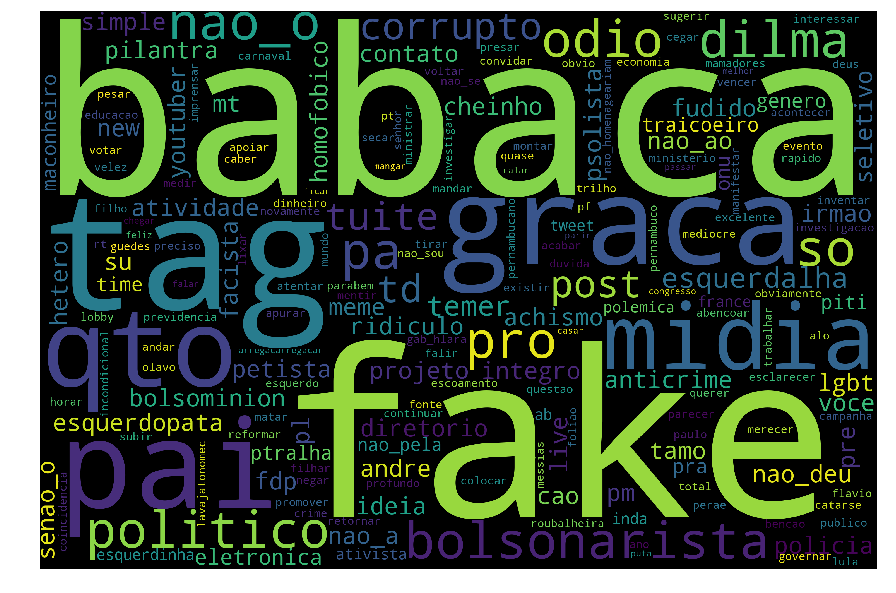

In [253]:
# Núvem de palavras do dicionário
print_wordcloud(bag_of_words, 'black')

### 5- Análise de Sentimento

#### 5.1 - Naive Bayes - Sklearn

In [154]:
from sklearn import naive_bayes
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [207]:
# Aplicando TD_IDF
tvec = TfidfVectorizer(max_features=3000, ngram_range=(1, 3))

# Aplicando modelo de Naive Bayes
naive = naive_bayes.MultinomialNB()

In [208]:
# Função para o Naive bayes

def nb_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    for train, test in kfold.split(X, Y):
        nb_fit = pipeline.fit(X[train], Y[train])
        prediction = nb_fit.predict(X[test])
        scores = nb_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('            neg  neut  pos')
        print('precision:',    precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*27)
        
    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))


In [248]:
# Função para o Naive bayes

def nb_teste(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    
    for train, test in kfold.split(X, Y):
        nb_fit = pipeline.fit(X[train], Y[train])
        prediction = nb_fit.predict(X[test])
        scores = nb_fit.score(X[test],Y[test])
        precision.append(precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=None))
        f1.append(recall_score(Y[test], prediction, average=None))
                         
    df_precision = pd.DataFrame(precision, columns =['Negative', 'Neutro', 'Positive'])
    df_recal = pd.DataFrame(recall, columns =['Negative', 'Neutro', 'Positive'])
    df_f1 = pd.DataFrame(f1, columns =['Negative', 'Neutro', 'Positive'])
    df = pd.concat([df_precision,df_recal,df_f1], axis=0)
                         
    return df


In [209]:
from sklearn.pipeline import Pipeline

original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', naive)
])

nb_cv(5, dataset['clean_text'], dataset['label'], original_pipeline, 'macro')

            neg  neut  pos
precision: [0.72 0.63 0.59]
recall:    [0.09 0.36 0.93]
f1 score:  [0.16 0.46 0.72]
---------------------------
            neg  neut  pos
precision: [0.62 0.65 0.58]
recall:    [0.06 0.35 0.94]
f1 score:  [0.1  0.46 0.72]
---------------------------
            neg  neut  pos
precision: [0.47 0.7  0.59]
recall:    [0.06 0.41 0.94]
f1 score:  [0.1  0.52 0.73]
---------------------------
            neg  neut  pos
precision: [0.88 0.69 0.59]
recall:    [0.1  0.38 0.95]
f1 score:  [0.18 0.49 0.73]
---------------------------
            neg  neut  pos
precision: [0.86 0.72 0.58]
recall:    [0.09 0.38 0.95]
f1 score:  [0.15 0.5  0.72]
---------------------------
accuracy: 60.47% (+/- 0.84%)
precision: 65.78% (+/- 5.38%)
recall: 46.53% (+/- 0.93%)
f1 score: 44.92% (+/- 1.37%)


In [192]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

In [193]:
ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),naive)
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),naive)

In [210]:
nb_cv(5, dataset.clean_text, dataset.label, ROS_pipeline, 'macro')

            neg  neut  pos
precision: [0.39 0.57 0.74]
recall:    [0.55 0.54 0.66]
f1 score:  [0.46 0.55 0.7 ]
---------------------------
            neg  neut  pos
precision: [0.35 0.55 0.73]
recall:    [0.47 0.55 0.64]
f1 score:  [0.4  0.55 0.68]
---------------------------
            neg  neut  pos
precision: [0.37 0.6  0.76]
recall:    [0.58 0.55 0.64]
f1 score:  [0.45 0.58 0.69]
---------------------------
            neg  neut  pos
precision: [0.39 0.66 0.75]
recall:    [0.6  0.56 0.67]
f1 score:  [0.47 0.61 0.71]
---------------------------
            neg  neut  pos
precision: [0.41 0.6  0.74]
recall:    [0.55 0.56 0.67]
f1 score:  [0.47 0.58 0.7 ]
---------------------------
accuracy: 60.33% (+/- 1.51%)
precision: 57.46% (+/- 1.85%)
recall: 58.54% (+/- 1.89%)
f1 score: 57.34% (+/- 1.72%)


In [211]:
nb_cv(5, dataset.clean_text, dataset.label, SMOTE_pipeline, 'macro')

            neg  neut  pos
precision: [0.39 0.59 0.74]
recall:    [0.54 0.55 0.67]
f1 score:  [0.45 0.57 0.7 ]
---------------------------
            neg  neut  pos
precision: [0.32 0.57 0.71]
recall:    [0.43 0.54 0.64]
f1 score:  [0.36 0.56 0.68]
---------------------------
            neg  neut  pos
precision: [0.38 0.64 0.75]
recall:    [0.56 0.55 0.68]
f1 score:  [0.45 0.6  0.71]
---------------------------
            neg  neut  pos
precision: [0.36 0.63 0.74]
recall:    [0.55 0.52 0.67]
f1 score:  [0.43 0.57 0.7 ]
---------------------------
            neg  neut  pos
precision: [0.39 0.6  0.74]
recall:    [0.56 0.53 0.67]
f1 score:  [0.46 0.56 0.71]
---------------------------
accuracy: 60.04% (+/- 1.56%)
precision: 57.00% (+/- 1.86%)
recall: 57.68% (+/- 2.06%)
f1 score: 56.71% (+/- 1.84%)


#### Plots

In [196]:
# Plot Consfusion matrix

from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [197]:
def nb_prediction(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    for train, test in kfold.split(X, Y):
        nb_fit = pipeline.fit(X[train], Y[train])
        prediction = nb_fit.predict(X[test])
        scores = nb_fit.score(X[test],Y[test])
    return prediction

In [198]:
def nb_Ytest(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    for train, test in kfold.split(X, Y):
        nb_fit = pipeline.fit(X[train], Y[train])
        prediction = nb_fit.predict(X[test])
        scores = nb_fit.score(X[test],Y[test])
    return Y[test]

Confusion matrix, without normalization
[[ 78  50  64]
 [ 26 128  61]
 [ 37  50 251]]


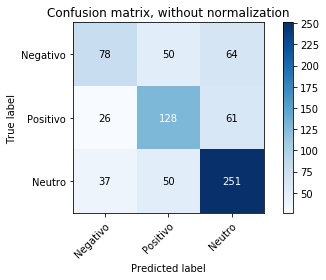

In [206]:
## Plot non-normalized confusion matrix
class_names = np.array(['Positivo','Neutro','Negativo'])
plot_confusion_matrix(nb_prediction(5, dataset.clean_text, dataset.label, ROS_pipeline, 'macro'),
                      nb_Ytest(5, dataset.clean_text, dataset.label, ROS_pipeline, 'macro'), classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

* https://scikit-learn.org/stable/modules/model_evaluation.html

##### Dúvidas:
* Criar um bigrama para meu_presidente, nosso_presidente
* O que fazer com tweets de notícia?
* Como substituir emoticons puxando de uma dicionário ou dataframe?
* Como substituir abreviações puxando de uma dicionário ou dataframe?
* Como indentificar tweets não relacionados ao assunto?